# Adding a custom model to use with CREME

This notebook illustrates how to add a new model and use it with CREME. We will use the pytorch version of Enformer from lucidrains as an example but the principles apply to any model. The main requirement is to define a method called `predict` with an input of shape [N, L, A] or [L, A] where N is the batch size, L is the sequence length and A is the number of channels. In our example the torch version of Enformer takes [N, L, A] shaped inputs (instead of the standard for pytorch - [N, A, L]). We will add load the model according to the lucidrains tutorial here https://github.com/lucidrains/enformer-pytorch and simply add the definition of the model `predict` method. Note, we could also define this in a separate scrip, similar to the definition of borzoi.

In [1]:
pip install enformer-pytorch --quiet

Note: you may need to restart the kernel to use updated packages.


In [99]:
import torch
from enformer_pytorch import Enformer
from enformer_pytorch import from_pretrained

import numpy as np
from creme import creme
from creme import utils

Define the custom prediction function

In [121]:
def make_a_prediction(self, x):
    # check to make sure shape is correct
    if len(x.shape) == 2:
        x = x[np.newaxis]

    x_torch = torch.from_numpy(x)
    preds = self(x_torch)[self.head].detach().numpy()

    if self.bin_index:
        preds = preds[:, self.bin_index, :]
    if self.track_index:
        preds = preds[..., self.track_index]

    
    return preds


Load the model

In [154]:
setattr(Enformer, "predict", make_a_prediction)
model = from_pretrained('EleutherAI/enformer-official-rough')
   

Add the additional methods and attributes

In [167]:
model.seq_length = 196608
model.head = 'human'
model.track_index = 5111
model.bin_index = None
# Enformer.predict = make_a_prediction

Load a sequence.
Note, this is an example sequence with a silencing context

In [131]:
fasta_path = f'../../../data/GRCh38.primary_assembly.genome.fa'
seq_parser = utils.SequenceParser(fasta_path)

gene = 'NFKBIZ_chr3_101849513_+'

gene_name, chrom, start, strand = gene.split('_')
wt_seq = seq_parser.extract_seq_centered(chrom, int(start), '-', model.seq_length)


Make a prediction and run context dependence test as an example

In [171]:
%%time
half_window_size = 5000 // 2
tss_tile_pos = [model.seq_length // 2 - half_window_size, model.seq_length // 2 + half_window_size]
wt_pred, mut_pred = creme.context_dependence_test(model, wt_seq, tss_tile_pos, 10, False)

CPU times: user 13min 7s, sys: 39.5 s, total: 13min 47s
Wall time: 1min 5s


<Axes: >

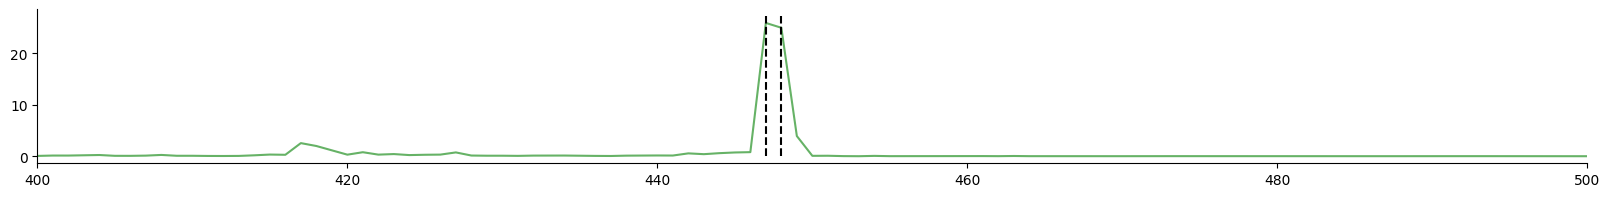

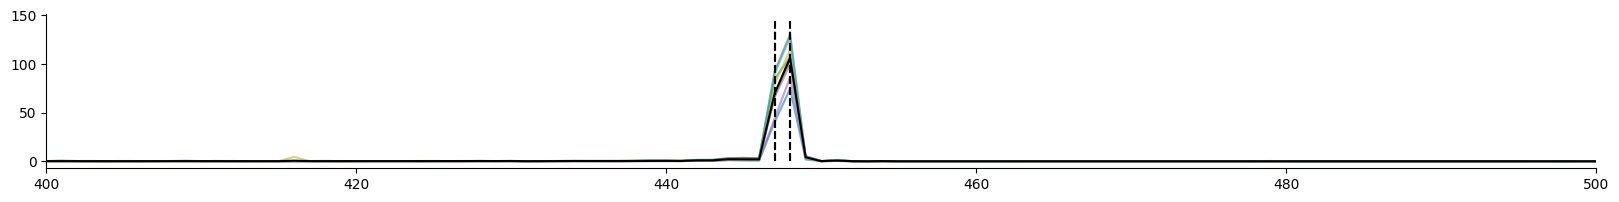

In [176]:
bins = [447, 448]
utils.plot_track(wt_pred, color='green', zoom=[400, 500], marks=bins)
ax=utils.plot_track(mut_pred, zoom=[400, 500], marks=bins)
utils.plot_track([mut_pred.mean(axis=0)], alpha=1, color='k', zoom=[400, 500], marks=bins, ax=ax)